# Chapter 7: Growth Modes

## Applying linear growth

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

c:\users\gregr\appdata\local\programs\python\python38\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df = pd.read_csv('../data/divvy_daily.csv')
df = df[['date', 'rides']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

In [3]:
model = Prophet(growth='linear',
                seasonality_mode='multiplicative',
                yearly_seasonality=4)

10:42:55 - cmdstanpy - INFO - Chain [1] start processing
10:42:56 - cmdstanpy - INFO - Chain [1] done processing


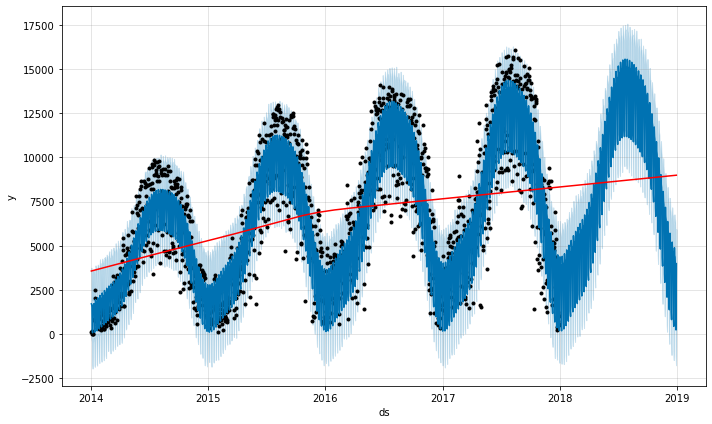

In [4]:
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

## Understanding the logistic function

In [5]:
import numpy as np
import random
random.seed(42)  # set random seed for repeatability

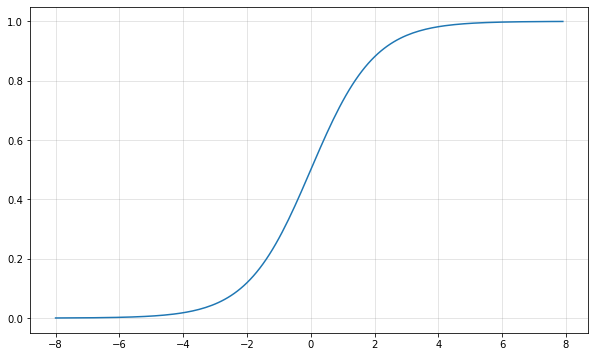

In [6]:
x = np.arange(-8, 8, .1)
y = [1 / (1 + np.e**(-val)) for val in x]

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.show()

## Saturating forecasts

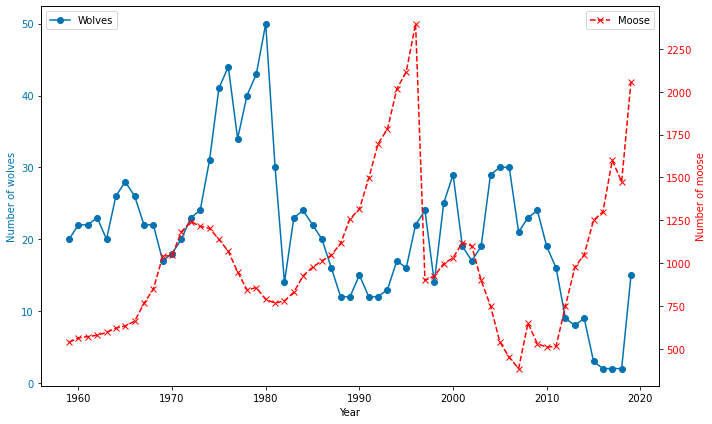

In [7]:
ir = pd.read_excel('../data/Data_wolves_moose_Isle_Royale_June2019.xlsx',
                     sheet_name='1. population level data',
                     header=1)

fig, ax1 = plt.subplots(figsize=(10, 6))
color = '#0072B2'
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of wolves', color=color)
ax1.plot(ir['year'], ir['wolves'], color=color, ls='-', marker='o', label='Wolves')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('Number of moose', color=color)  # we already handled the x-label with ax1
ax2.plot(ir['year'], ir['moose'], color=color, ls='--', marker='x', label='Moose')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Increasing logistic growth

In [8]:
x = pd.to_datetime(pd.date_range('1995-01', '2004-02', freq='M').strftime("%Y-%b").tolist())
y = [1 / (1 + np.e ** (-.03 * (val - 50))) for val in range(len(x))]  # create logistic curve
y = [y[idx] + y[idx] * .01 * np.sin((idx - 2) * (360 / 12) * (np.pi / 180)) for idx in range(len(y))]  # add sinusoidal variation
y = [val + random.uniform(-.01, .01) for val in y]  # add noise
y = [int(500 * val) for val in y]  # scale up

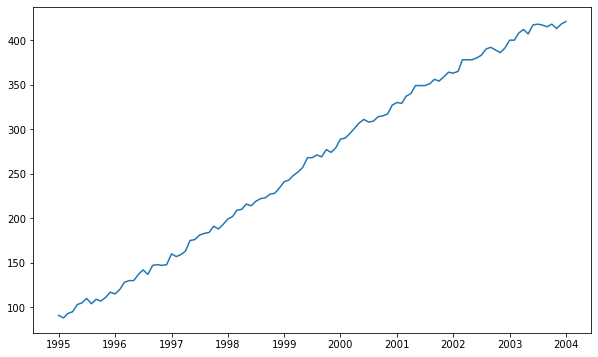

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.show()

#### Modeling with linear growth

In [10]:
df = pd.DataFrame({'ds': pd.to_datetime(x), 'y': y})

10:43:00 - cmdstanpy - INFO - Chain [1] start processing
10:43:00 - cmdstanpy - INFO - Chain [1] done processing


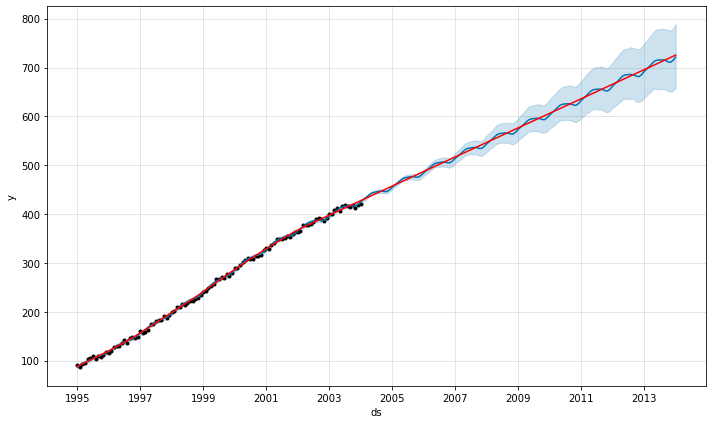

In [11]:
model = Prophet(growth='linear',
                yearly_seasonality=3,
                seasonality_mode='multiplicative')
model.fit(df)
future = model.make_future_dataframe(periods=12 * 10, freq='M')
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

#### Modeling with logistic growth

In [12]:
df['cap'] = 500

In [13]:
model = Prophet(growth='logistic',
                yearly_seasonality=3,
                seasonality_mode='multiplicative')
model.fit(df)
future = model.make_future_dataframe(periods=12 * 10, freq='M')

10:43:01 - cmdstanpy - INFO - Chain [1] start processing
10:43:01 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
future['cap'] = 500

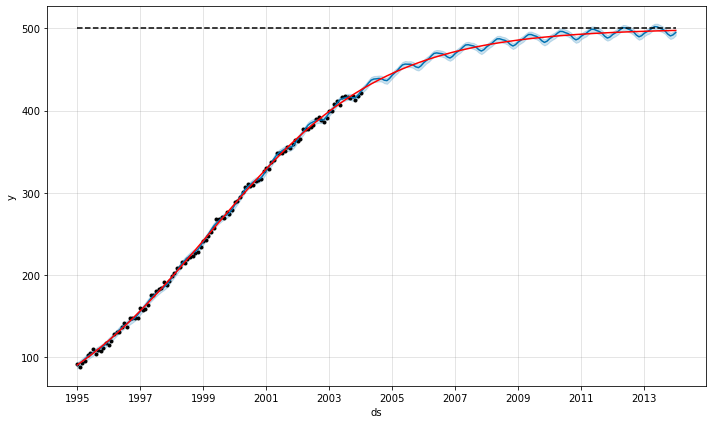

In [15]:
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

#### Non-constant cap

In [16]:
def set_cap(row, df):
    if row.year < 2007:
        return 500
    else:
        pop_2007 = 500
        idx_2007 = df[df['ds'].dt.year == 2007].index[0]
        idx_date = df[df['ds'] == row].index[0]
        return pop_2007 + 2 * (idx_date - idx_2007)

In [17]:
df['cap'] = df['ds'].apply(set_cap, args=(df,))

10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:03 - cmdstanpy - INFO - Chain [1] done processing


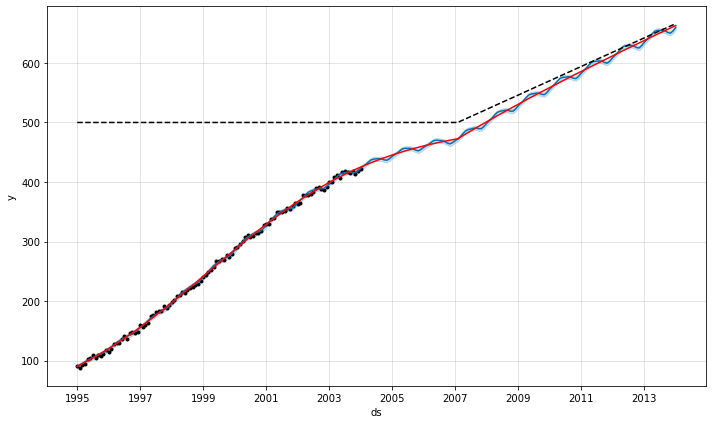

In [18]:
model = Prophet(growth='logistic',
                yearly_seasonality=3,
                seasonality_mode='multiplicative')
model.fit(df)
future = model.make_future_dataframe(periods=12 * 10, freq='M')
future['cap'] = future['ds'].apply(set_cap, args=(future,))
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

### Decreasing logistic growth

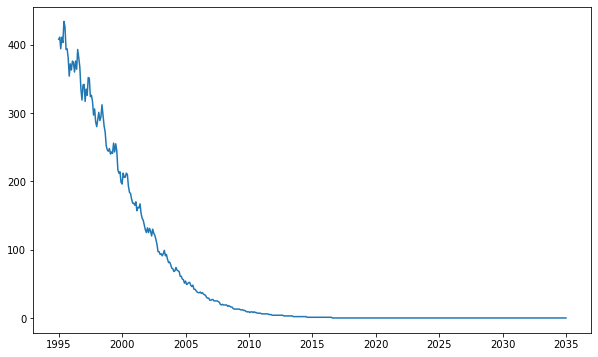

In [19]:
x = pd.to_datetime(pd.date_range('1995-01','2035-02', freq='M').strftime("%Y-%b").tolist())
y = [1 - 1 / (1 + np.e ** (-.03 * (val - 50))) for val in range(len(x))]  # create logistic curve
y = [y[idx] + y[idx] * .05 * np.sin((idx - 2) * (360 / 12) * (np.pi / 180)) for idx in range(len(y))]  # add sinusoidal variation
y = [val + 5 * val * random.uniform(-.01, .01) for val in y]  # add noise
y = [int(500 * val) for val in y]  # scale up
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.show()

In [20]:
df2 = pd.DataFrame({'ds': pd.to_datetime(x), 'y': y})
df2 = df2[df2['ds'].dt.year < 2006]
df2['cap'] = 500
df2['floor'] = 0

10:43:04 - cmdstanpy - INFO - Chain [1] start processing
10:43:04 - cmdstanpy - INFO - Chain [1] done processing


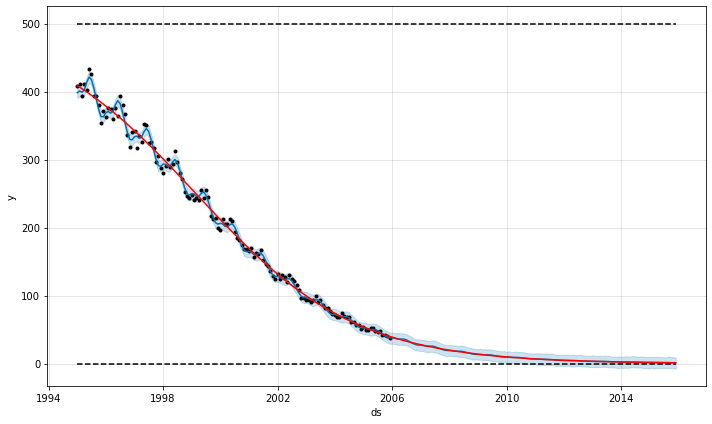

In [21]:
model = Prophet(growth='logistic',
                yearly_seasonality=3,
                seasonality_mode='multiplicative')
model.fit(df2)
future = model.make_future_dataframe(periods=12 * 10, freq='M')
future['cap'] = 500
future['floor'] = 0
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

## Applying flat growth

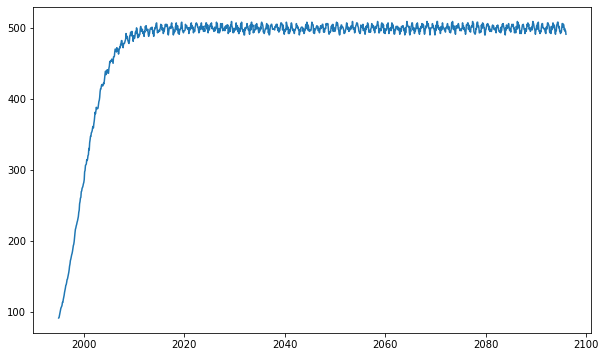

In [22]:
x = pd.to_datetime(pd.date_range('1995-01','2096-02', freq='M').strftime("%Y-%b").tolist())
y = [1 / (1 + np.e ** (-.03 * (val - 50))) for val in range(len(x))]  # create logistic curve
y = [y[idx] + y[idx] * .01 * np.sin((idx - 2) * (360 / 12) * (np.pi / 180)) for idx in range(len(y))]  # add sinusoidal variation
y = [val + 1 * val * random.uniform(-.01, .01) for val in y]  # add noise
y = [int(500 * val) for val in y]  # scale up
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.show()

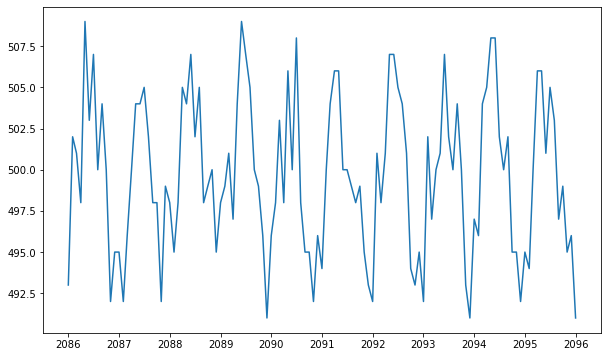

In [23]:
df = pd.DataFrame({'ds': pd.to_datetime(x), 'y': y})
df = df[df['ds'].dt.year > 2085]
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'])
plt.show()

10:43:06 - cmdstanpy - INFO - Chain [1] start processing
10:43:06 - cmdstanpy - INFO - Chain [1] done processing


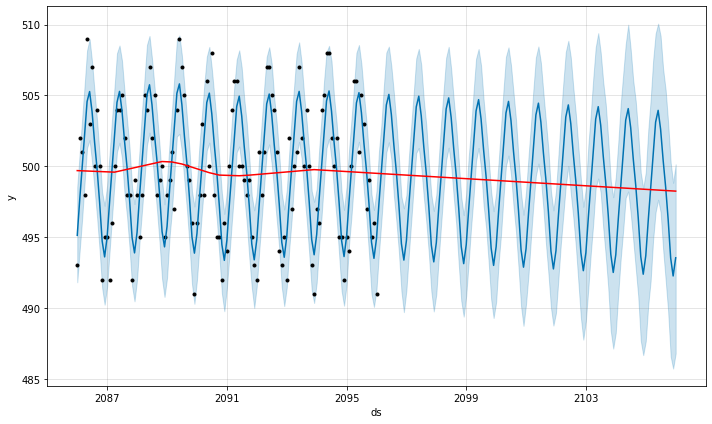

In [24]:
model = Prophet(growth='linear',
                yearly_seasonality=3,
                seasonality_mode='multiplicative')
model.fit(df)
future = model.make_future_dataframe(periods=12 * 10, freq='M')
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

10:43:08 - cmdstanpy - INFO - Chain [1] start processing
10:43:08 - cmdstanpy - INFO - Chain [1] done processing


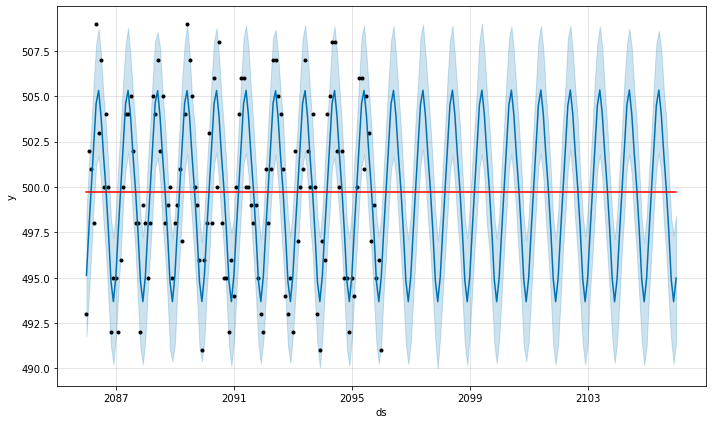

In [25]:
model = Prophet(growth='flat',
                yearly_seasonality=3)
model.fit(df)
future = model.make_future_dataframe(periods=12 * 10, freq='M')
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

## Creating a custom trend

In [26]:
df = pd.read_csv('../data/clothing_retailer.csv')
df['ds'] = pd.to_datetime(df['ds'])

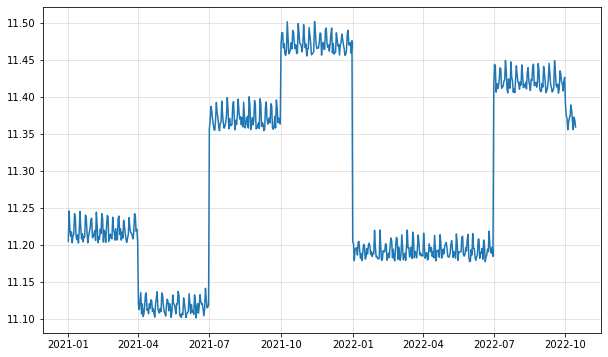

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'])
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.ticklabel_format(useOffset=False, axis='y')
plt.show()

10:43:10 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1] done processing


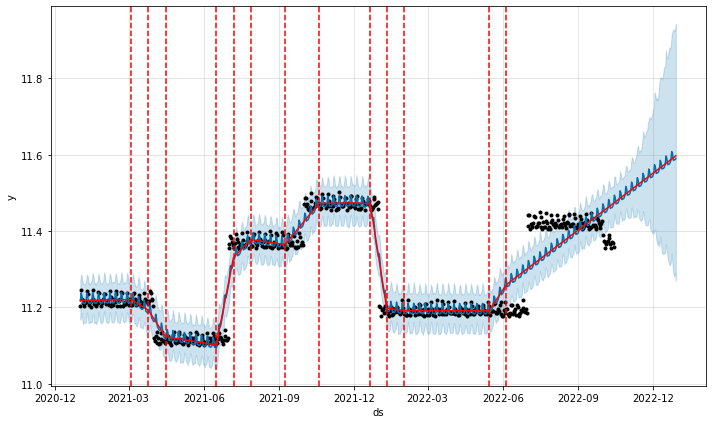

In [28]:
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(76)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

In [29]:
class ProphetStepWise(Prophet):
    
    def fit(self, df, **kwargs):
        m = super().fit(df, **kwargs)
        if self.growth == 'flat' and self.changepoints is not None:
            kinit = self.stepwise_growth_init(self.history, self.changepoints)
            self.params['m_'] = kinit[1]
        return self
        

    @staticmethod
    def stepwise_growth_init(df, changepoints):
        k = 0
        if len(changepoints) == 0:
            k = 0
            m = df['y_scaled'].mean()
        else:
            m = []
            last_cp = pd.Timestamp.min
            for cp in changepoints:
                df_  = df[(df.ds > last_cp) & (df.ds <= cp)]['y_scaled']
                m.append(df_.mean())
                last_cp = cp
            cp = changepoints.iloc[-1]
            df_  = df[df.ds > cp]['y_scaled']
            m.append(df_.mean())
        return k, m
    
    @staticmethod
    def stepwise_trend(t, m, changepoint_ts):
        if changepoint_ts[0] == 0:
            m_t = m * np.ones_like(t)
        else:
            m_t = np.ones_like(t)
            last_t_s = changepoint_ts[0]-1
            for s, t_s in enumerate(changepoint_ts):
                indx = (t <= t_s) & (t > last_t_s)
                m_t[indx] = m[s]
                last_t_s = t_s

            t_s = changepoint_ts[-1]
            indx = (t > t_s) 
            m_t[indx] = m[-1]
        return m_t
    
    def sample_predictive_trend(self, df, iteration):
        """Simulate the trend using the extrapolated generative model.
        Parameters
        ----------
        df: Prediction dataframe.
        iteration: Int sampling iteration to use parameters from.
        Returns
        -------
        np.array of simulated trend over df['t'].
        """
        k = self.params['k'][iteration]
        m = self.params['m'][iteration]
        deltas = self.params['delta'][iteration]

        t = np.array(df['t'])
        T = t.max()

        # New changepoints from a Poisson process with rate S on [1, T]
        if T > 1:
            S = len(self.changepoints_t)
            n_changes = np.random.poisson(S * (T - 1))
        else:
            n_changes = 0
        if n_changes > 0:
            changepoint_ts_new = 1 + np.random.rand(n_changes) * (T - 1)
            changepoint_ts_new.sort()
        else:
            changepoint_ts_new = []

        # Get the empirical scale of the deltas, plus epsilon to avoid NaNs.
        lambda_ = np.mean(np.abs(deltas)) + 1e-8

        # Sample deltas
        deltas_new = np.random.laplace(0, lambda_, n_changes)

        # Prepend the times and deltas from the history
        changepoint_ts = np.concatenate((self.changepoints_t,
                                         changepoint_ts_new))
        deltas = np.concatenate((deltas, deltas_new))

        if self.growth == 'linear':
            trend = self.piecewise_linear(t, deltas, k, m, changepoint_ts)
        elif self.growth == 'logistic':
            cap = df['cap_scaled']
            trend = self.piecewise_logistic(t, cap, deltas, k, m,
                                            changepoint_ts)
        elif self.growth == 'flat':
            trend = self.stepwise_trend(t, self.params['m_'], self.changepoints_t)

        return trend * self.y_scale + df['floor']
    
    def predict_trend(self, df):
        """Predict trend using the prophet model.
        Parameters
        ----------
        df: Prediction dataframe.
        Returns
        -------
        Vector with trend on prediction dates.
        """
        k = np.nanmean(self.params['k'])
        m = np.nanmean(self.params['m'])
        deltas = np.nanmean(self.params['delta'], axis=0)

        t = np.array(df['t'])
        if self.growth == 'linear':
            trend = self.piecewise_linear(t, deltas, k, m, self.changepoints_t)
        elif self.growth == 'logistic':
            cap = df['cap_scaled']
            trend = self.piecewise_logistic(
                t, cap, deltas, k, m, self.changepoints_t)
        elif self.growth == 'flat':
            # constant trend
            trend = self.stepwise_trend(t, self.params['m_'], self.changepoints_t)
        return trend * self.y_scale + df['floor']

10:43:12 - cmdstanpy - INFO - Chain [1] start processing
10:43:12 - cmdstanpy - INFO - Chain [1] done processing


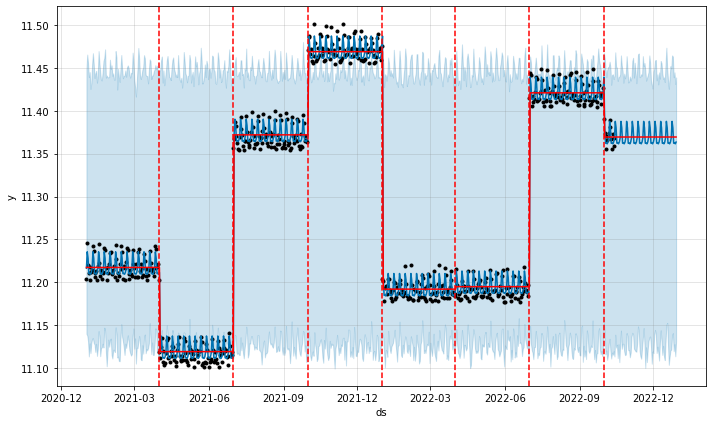

In [30]:
model = ProphetStepWise(growth='flat',
                        changepoints= ['2021-04-01',
                                       '2021-07-01',
                                       '2021-10-01',
                                       '2022-01-01',
                                       '2022-04-01',
                                       '2022-07-01',
                                       '2022-10-01'])
model.fit(df)

future = model.make_future_dataframe(76)
forecast = model.predict(future)

fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, threshold=0.00);